In [84]:
from xarray.backends import NetCDF4DataStore
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from siphon.catalog import TDSCatalog
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np
import pandas as pd
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime, timedelta
import xarray as xr

In [85]:
# Acesso ao catalogo THREDDS Dataset Server (TDS) 
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
                      'Global_0p25deg/catalog.xml?dataset=grib/NCEP/GFS/Global_0p25deg/Best')
best_ds = list(best_gfs.datasets.values())[0]
ncss = best_ds.subset()
query = ncss.query()

In [86]:
# Pega GFS recortado em formato nc, todas as variáveis
query.lonlat_box(north=-20, south=-35, east=315, west=285).time(datetime(2020,4,27,12))
query.accept('netcdf4')
query.variables('all')

var=all&time=2020-04-27T12%3A00%3A00&west=285&east=315&south=-35&north=-20&accept=netcdf4

In [87]:
# Acessar banco de dados
query.lonlat_box(north=-20, south=-35, east=315, west=285).time(datetime(2020,4,27,12))
query.accept('netcdf4')
query.variables('all')
# Pegar dado
data = ncss.get_data(query)
data = xr.open_dataset(NetCDF4DataStore(data))

print('Lista de variáveis disponíveis')
list(data)

Lista de variáveis disponíveis


['Total_ozone_entire_atmosphere_single_layer',
 'LatLon_Projection',
 'Ozone_Mixing_Ratio_isobaric',
 'Momentum_flux_u-component_surface_Mixed_intervals_Average',
 'Momentum_flux_v-component_surface_Mixed_intervals_Average',
 'Surface_Lifted_Index_surface',
 'Downward_Short-Wave_Radiation_Flux_surface_Mixed_intervals_Average',
 'Downward_Long-Wave_Radp_Flux_surface_Mixed_intervals_Average',
 'Pressure_middle_cloud_top_Mixed_intervals_Average',
 'Pressure_low_cloud_top_Mixed_intervals_Average',
 'Pressure_low_cloud_bottom_Mixed_intervals_Average',
 'Pressure_middle_cloud_bottom_Mixed_intervals_Average',
 'Ventilation_Rate_planetary_boundary',
 'Pressure_convective_cloud_bottom',
 'Pressure_convective_cloud_top',
 'Vertical_Speed_Shear_tropopause',
 'Wind_speed_gust_surface',
 'Pressure_of_level_from_which_parcel_was_lifted_pressure_difference_layer',
 'Pressure_high_cloud_bottom_Mixed_intervals_Average',
 'MSLP_Eta_model_reduction_msl',
 'Pressure_high_cloud_top_Mixed_intervals_Average'

In [89]:
# temperatura na superfície
temp_3d = data['Temperature_surface']-275
# taxa de precipitação em superfície
precip_rate_sfc = data['Precipitation_rate_surface']
# componentes u,v do vento em níveis isobáricos
u_wnd_isob = data['u-component_of_wind_isobaric']
v_wnd_isob = data['v-component_of_wind_isobaric']
# conteudo de água precipitável
conteudo_agua = data['Precipitable_water_entire_atmosphere_single_layer']
# pressção na superfície
press_sfc = data['Pressure_surface']
# temperatura em níveis isobáricos
temp_isob = data['Temperature_isobaric']
# pressão reduzida ao nível médio do mar
slp = data['MSLP_Eta_model_reduction_msl']
slp = slp/10**2
# velocidade do vento na superfície
speed_sfc = np.sqrt((u_wnd_isob**2)+(v_wnd_isob**2))[0,-1]
# ?
precip = data['Total_precipitation_surface_Mixed_intervals_Accumulation']
# altura potêncial no nível de 500mb
hgt_500 = data['5-Wave_Geopotential_Height_isobaric']


In [90]:
# pegar data válida para a previsão
day = pd.to_datetime(temp_3d.time.values).day
year = pd.to_datetime(temp_3d.time.values).year
month = pd.to_datetime(temp_3d.time.values).month
hour = pd.to_datetime(temp_3d.time.values).hour

In [91]:
# lat/lon
lat_1d = data['lat']
lon_1d = data['lon']
# Combine latitude and longitudes 
lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d)

# VenTo: Falta adicionar BARBS

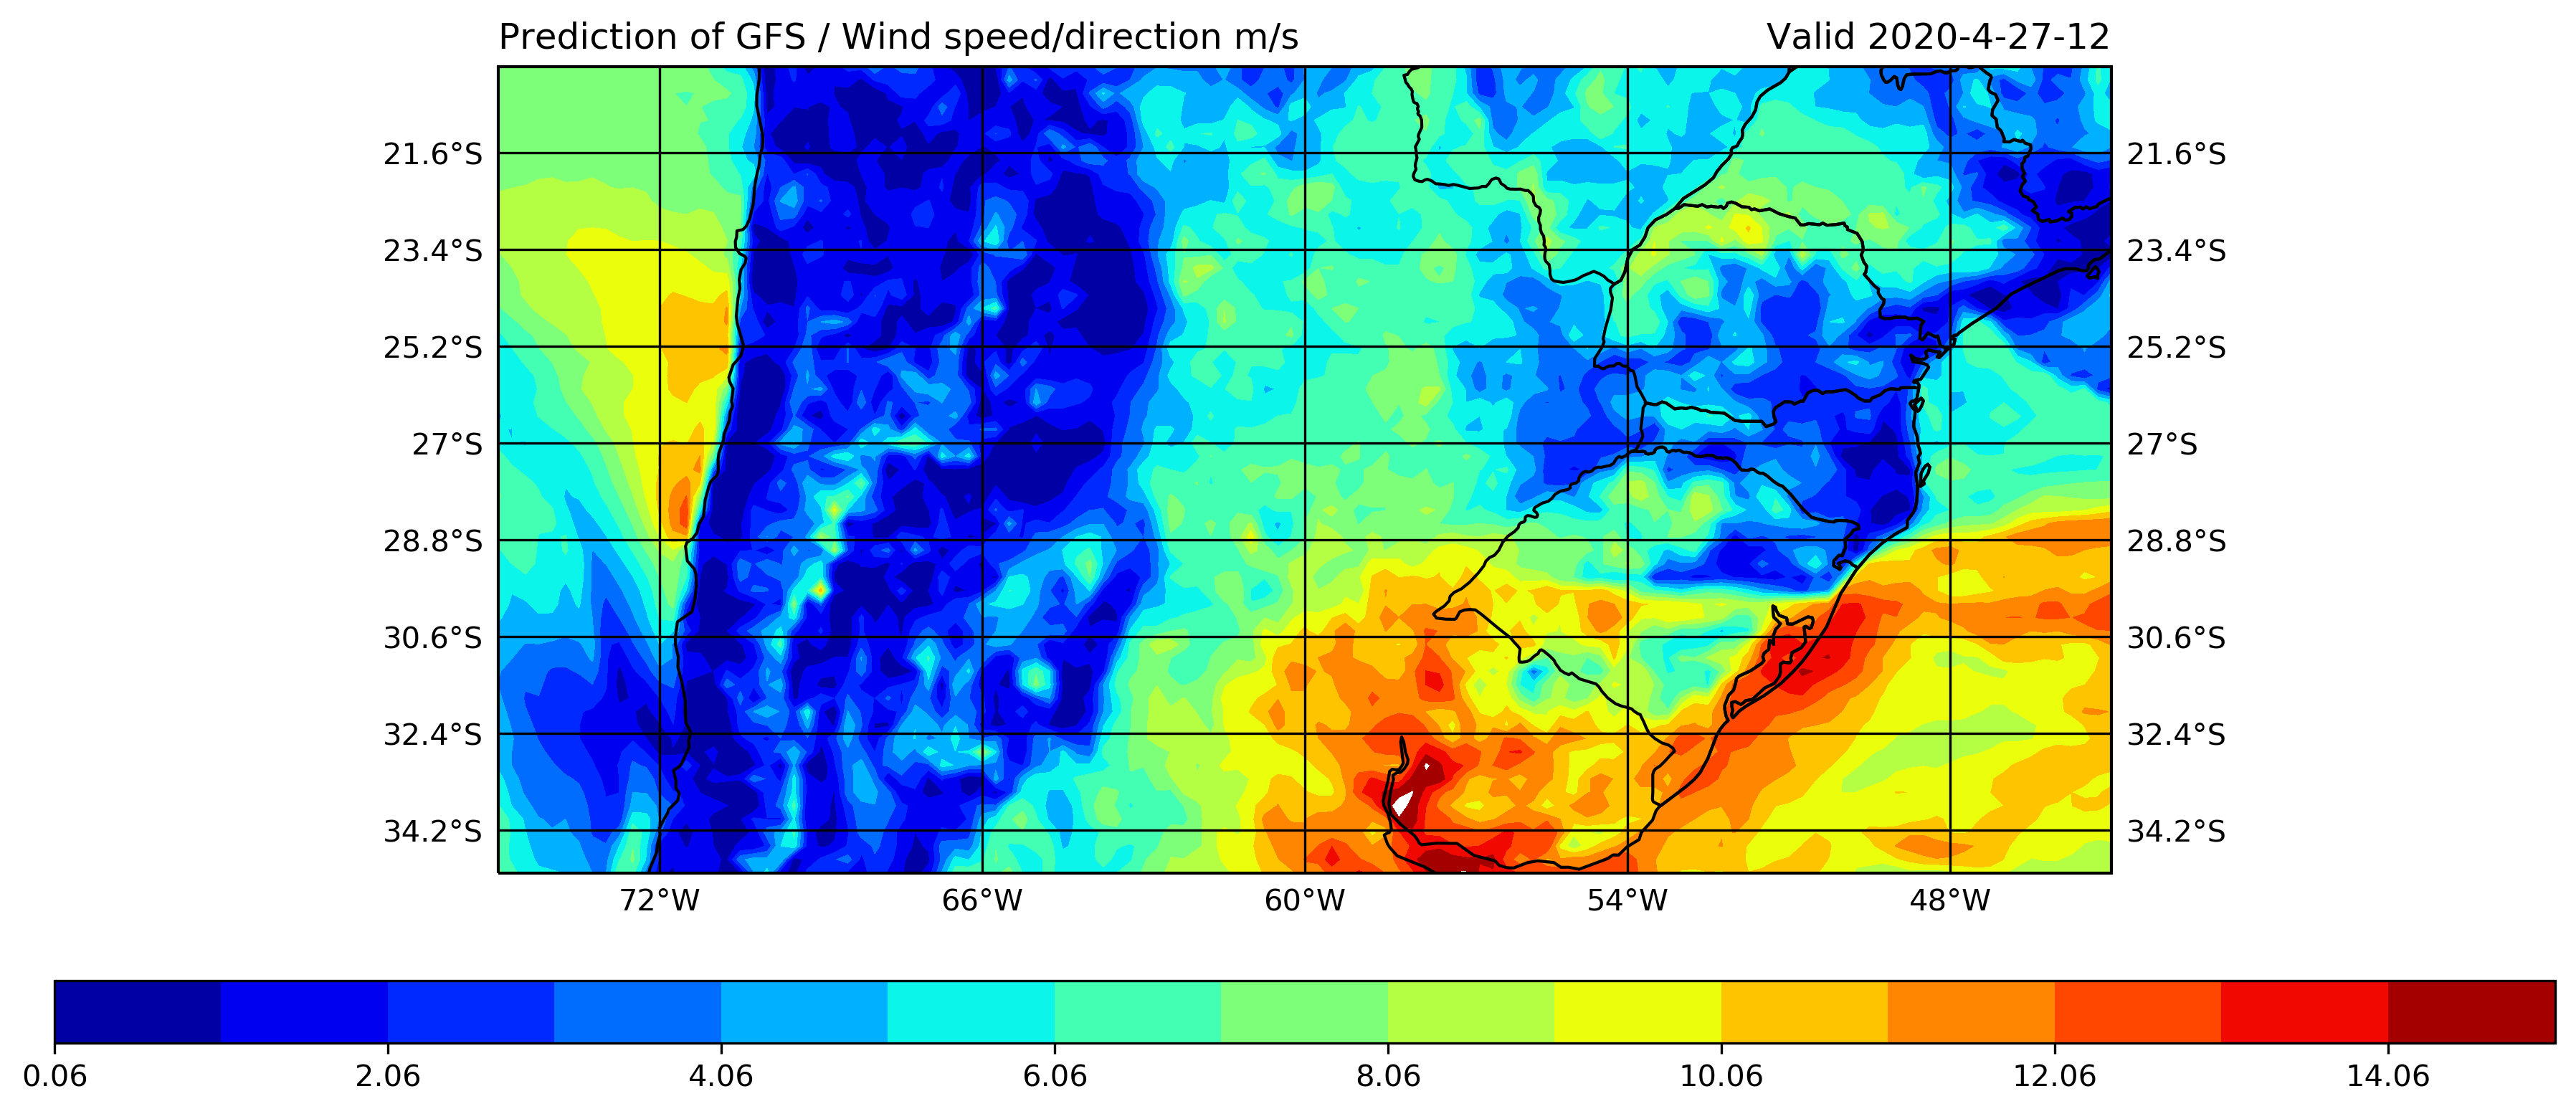

In [37]:
fig = plt.figure(1, figsize=(15, 5), dpi=300)
ax = plt.subplot(111, projection=ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cf.COASTLINE.with_scale('50m'))
ax.add_feature(cf.STATES.with_scale('50m'))


# Plot 500-hPa Colorfill Wind Speeds in knots
clevs_500_sped = np.arange(speed_sfc.min().values,\
                           speed_sfc.max().values)
cfs = ax.contourf(lon_2d, lat_2d, speed_sfc, clevs_500_sped, cmap=get_cmap('jet'),
                 transform=ccrs.PlateCarree())
plt.colorbar(cfs, orientation='horizontal', pad=0.1, aspect=40)




# Plot 500-hPa wind barbs in knots, regrid to reduce number of barbs
ax.barbs(lon_2d, lat_2d, u_wnd_isob[0,0,:,:].values, v_wnd_isob[0,0,:,:].values, 
         color='black', regrid_shape=2000, transform=ccrs.PlateCarree())


plt.title('Prediction of GFS / Wind speed/direction {}'.format(u_wnd_isob.units), loc='left')
plt.title('Valid {}-{}-{}-{}'.format(int(year.values),\
                                     int(month.values),\
                                     int(day.values),int(hour.values)), loc='right')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)

gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),color='black')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = True


## Agua precipitável

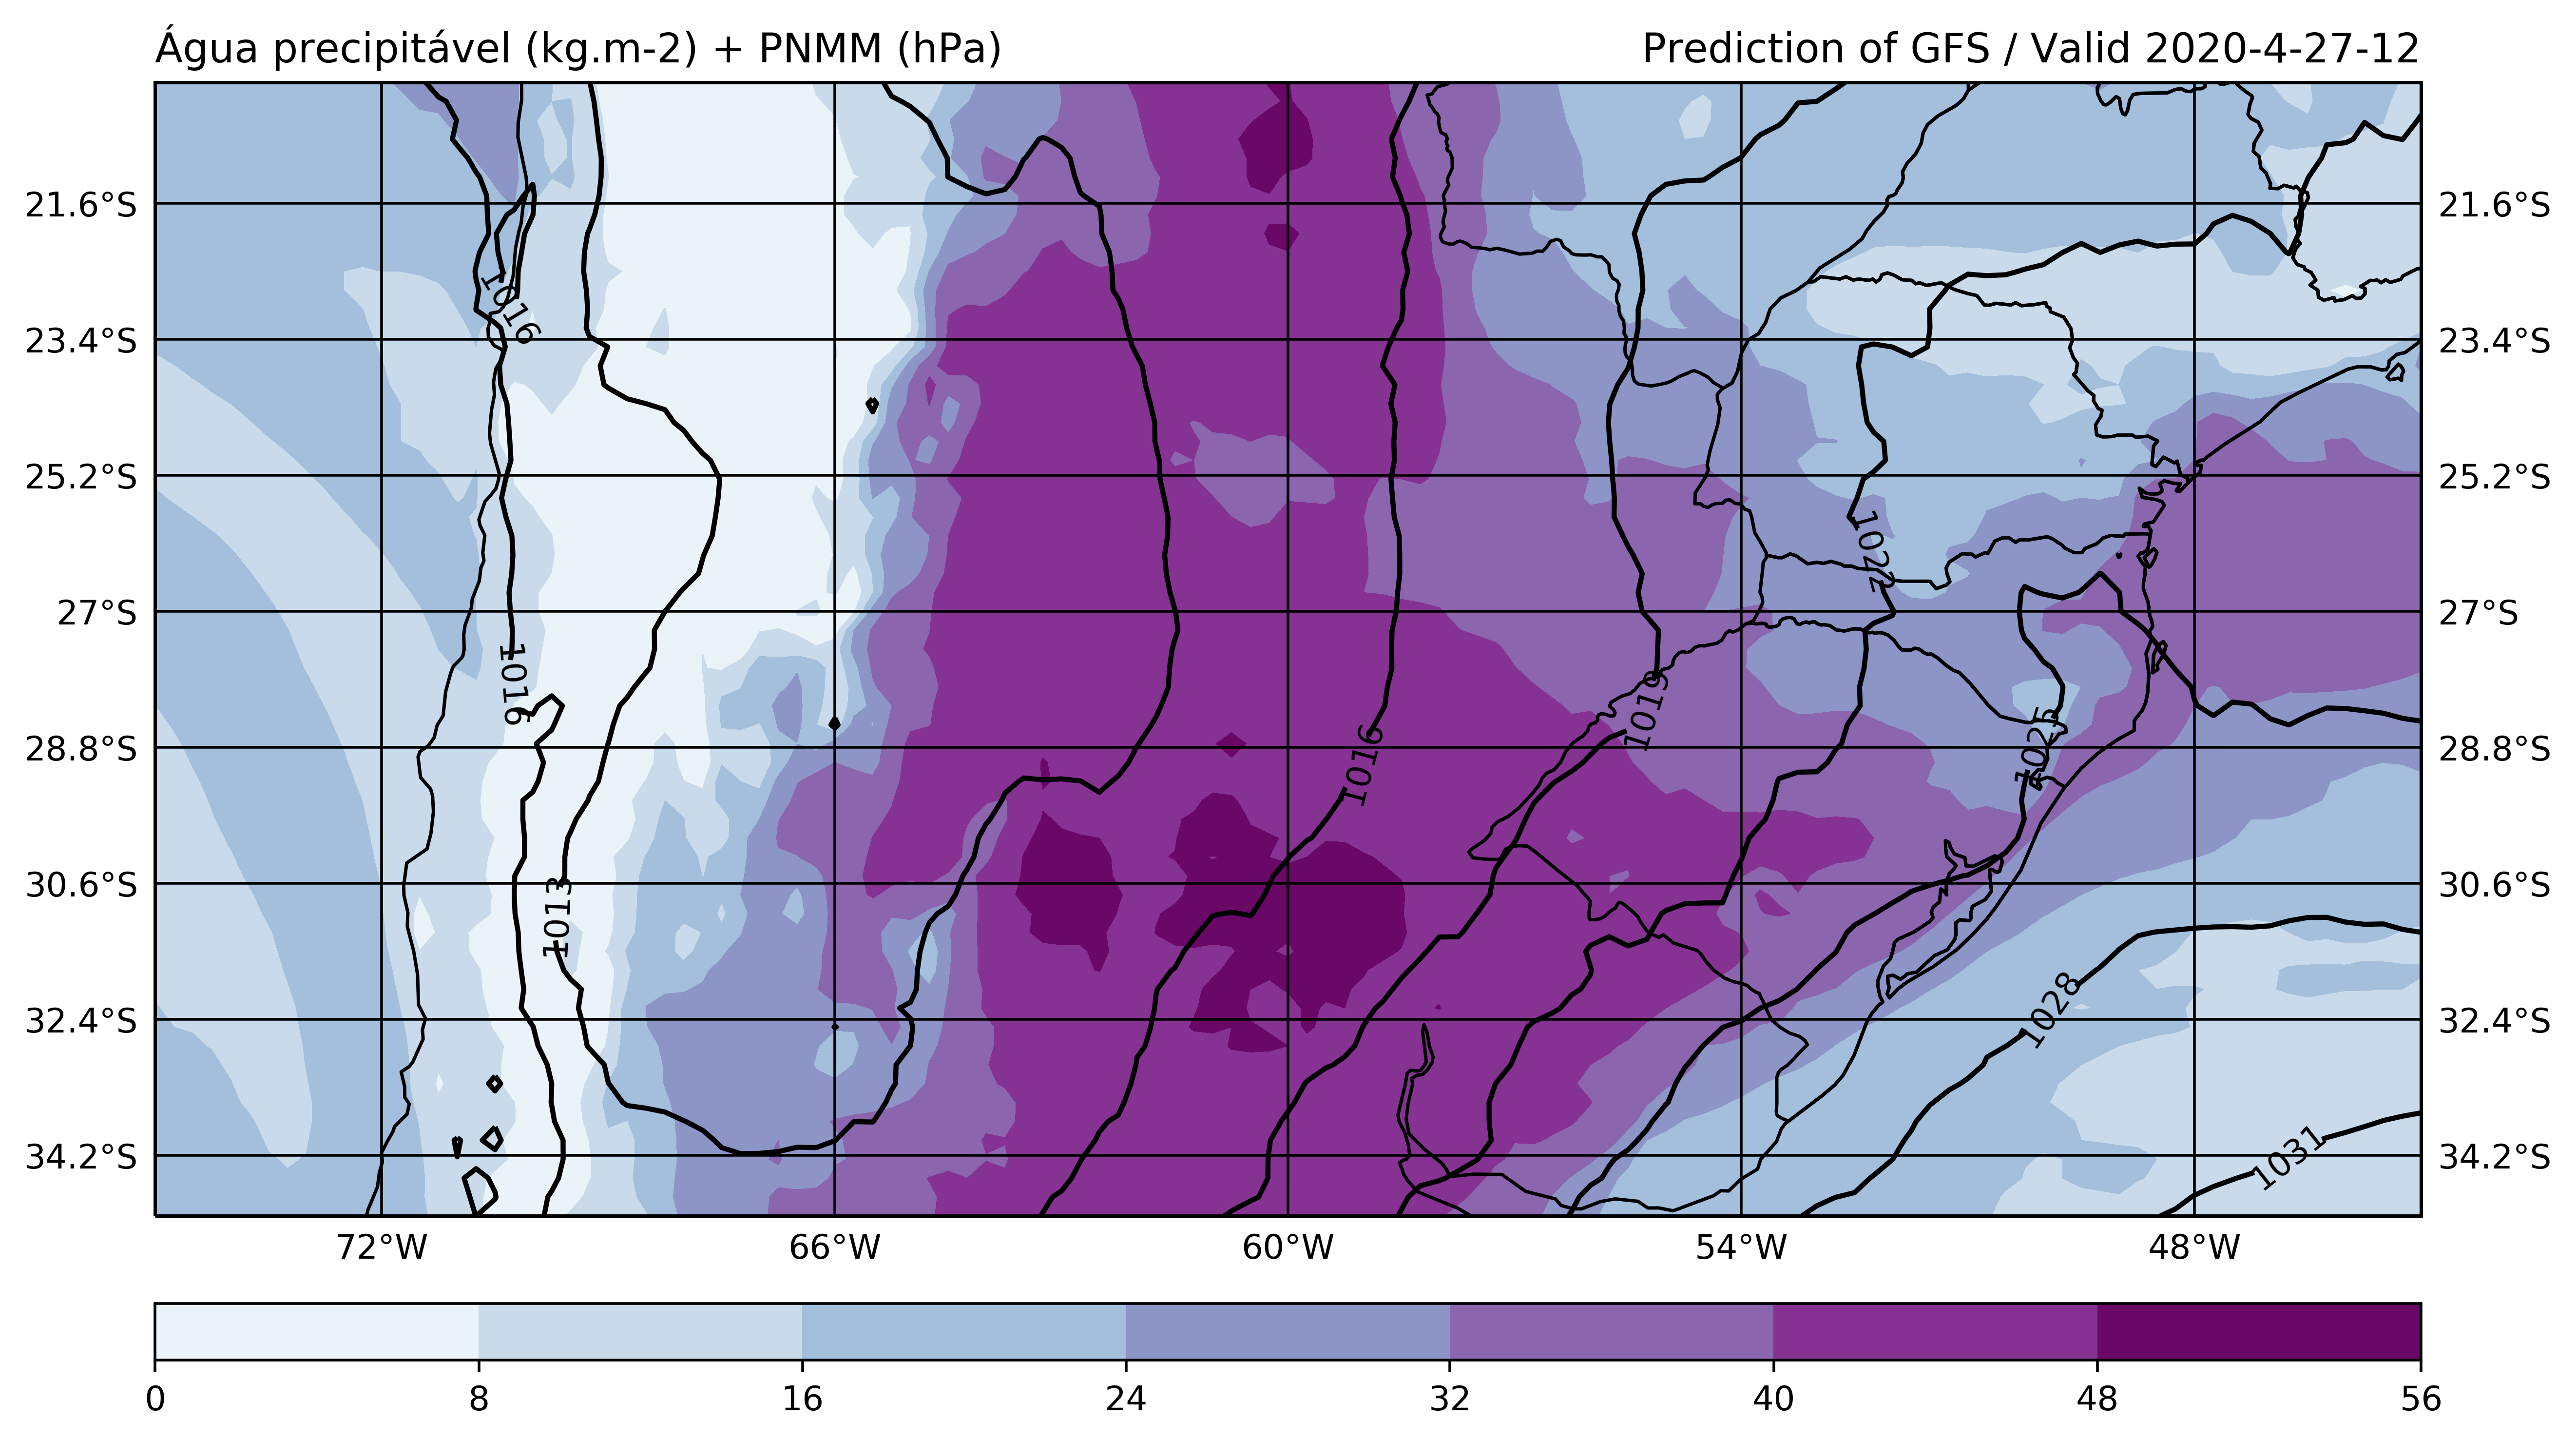

In [125]:
fig = plt.figure(1, figsize=(12, 12), dpi=500)
ax = plt.subplot(111, projection=ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cf.COASTLINE.with_scale('50m'))
ax.add_feature(cf.STATES.with_scale('50m'))


color_temp = ax.contourf(lon_2d, lat_2d, preciptable_water[0,:,:], cmap=plt.cm.BuPu, # get_cmap('jet')
                 transform=ccrs.PlateCarree())
plt.colorbar(color_temp, orientation='horizontal', pad=.03, aspect=40)


# Plot isolines of temperature at surface in °C
clevs_slp = np.arange(slp.min().values,\
                           slp.max().values, 3)
line_temp = ax.contour(lon_2d, lat_2d, slp[0,:,:], clevs_slp, colors='black',
                transform=ccrs.PlateCarree())
plt.clabel(line_temp, fmt='%d')



plt.title('Água precipitável ({}) + PNMM ({})'.format(preciptable_water.units,'hPa'),\
          loc='left')
plt.title('Prediction of GFS / Valid {}-{}-{}-{}'.format(int(year.values),\
                                     int(month.values),\
                                     int(day.values),int(hour.values)), loc='right')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)

gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),color='black')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = True
plt.savefig('/home/lucas/github/waterprecip_pnmm.png')

# Temperature

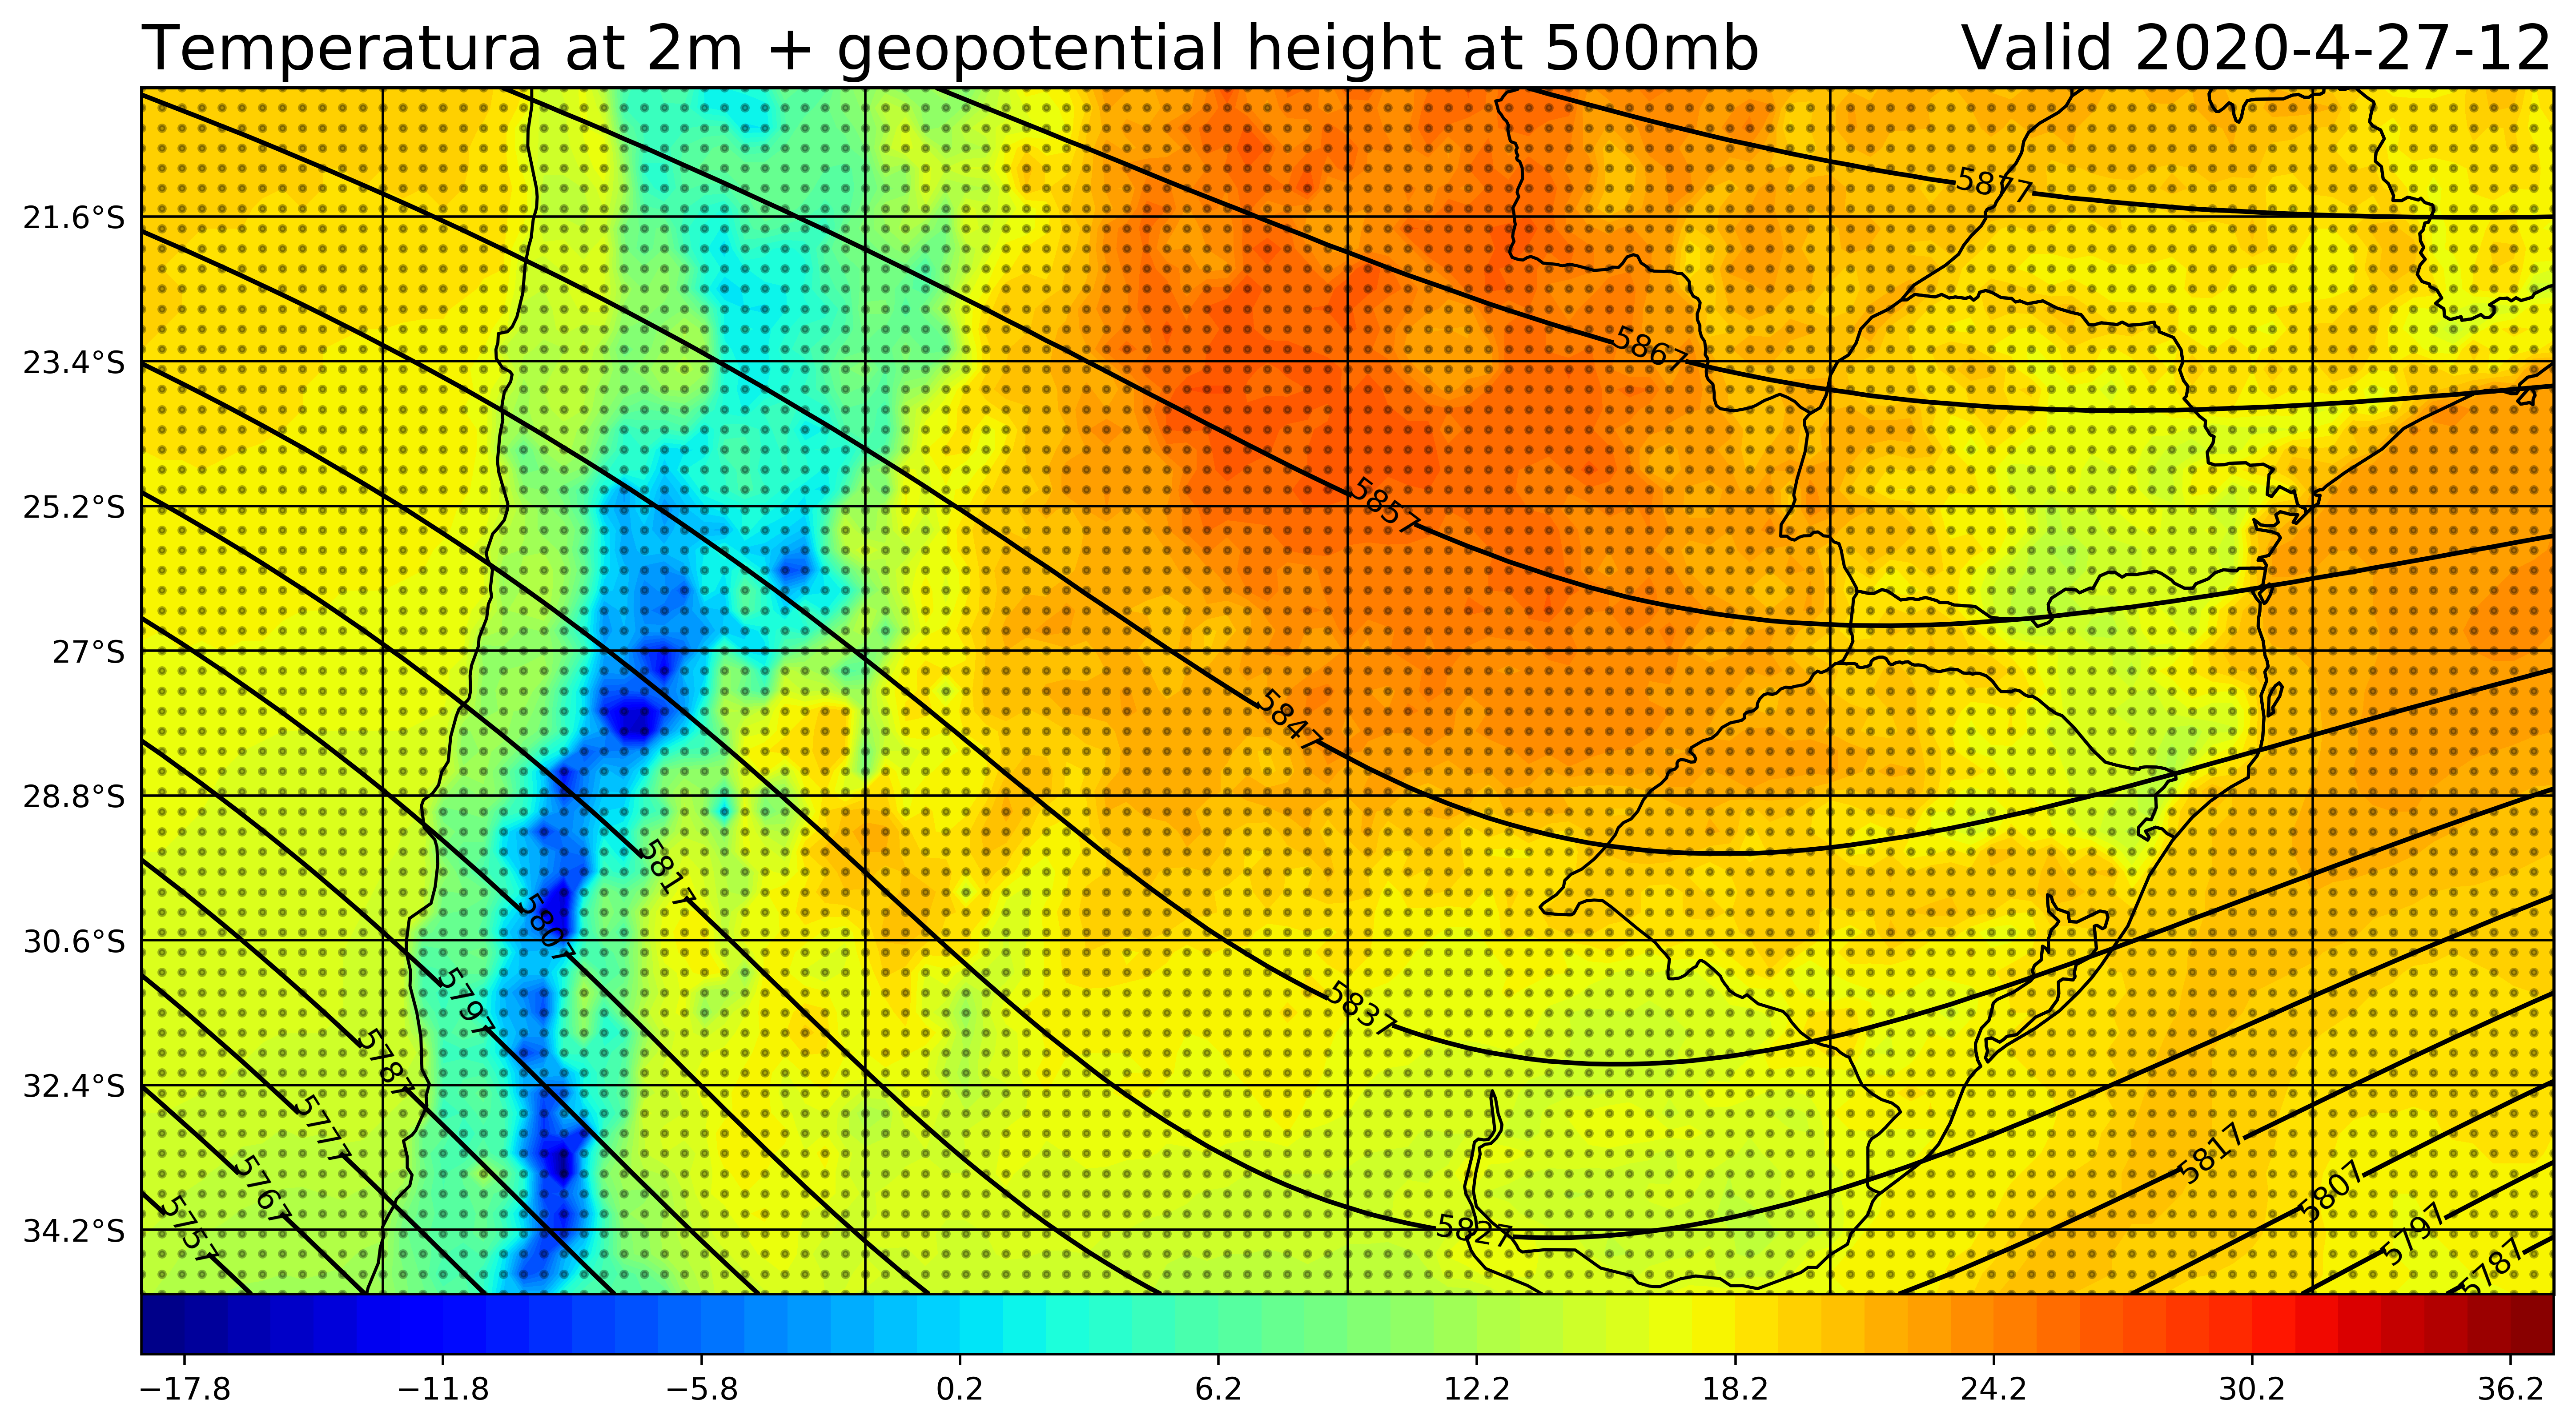

In [138]:
fig = plt.figure(1, figsize=(14, 12), dpi=500)
ax = plt.subplot(111, projection=ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cf.COASTLINE.with_scale('50m'))
ax.add_feature(cf.STATES.with_scale('50m'))

# Plot temperature at surface in °C
clevs_ctt = np.arange(temp_3d[0,:,:].min().values,\
                           temp_3d[0,:,:].max().values+10, 1)
color_temp = ax.contourf(lon_2d, lat_2d, temp_3d[0,:,:], clevs_ctt, cmap=get_cmap('jet'), #plt.cm.BuPu 
                 transform=ccrs.PlateCarree())

# Plot isolines of gpt height at 500mb
clevs_hgt = np.arange(hgt_500[0,0,:,:].min().values,\
                           hgt_500[0,0,:,:].max().values,10)
line_hgt = ax.contour(lon_2d, lat_2d, hgt_500[0,0,:,:].values, clevs_hgt, colors='black',
                transform=ccrs.PlateCarree())
plt.clabel(line_hgt, fmt='%d', fontsize=10)



plt.colorbar(color_temp, orientation='horizontal', pad=0, aspect=40)

plt.title('Temperatura at 2m + geopotential height at 500mb', loc='left',fontsize=20)
plt.title('Valid {}-{}-{}-{}'.format(int(year.values),\
                                     int(month.values),\
                                     int(day.values),int(hour.values)), loc='right',fontsize=20)

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)

gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),color='black')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
# Plot markers for each lat/long to show grid points for 0.25 deg GFS
ax.plot(lon_2d.flatten(), lat_2d.flatten(), linestyle='none', marker='o',
        color='black', markersize=2, alpha=0.3, transform=ccrs.PlateCarree())
plt.savefig('/home/lucas/github/t2m_h50mm.png')

In [ ]:
import numpy as np
from netCDF4 import num2date
from metpy.units import units

# Reduce the dimensions of the data and get as an array with units
temp_2d = temp_3d.metpy.unit_array.squeeze()

# Combine latitude and longitudes 
lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d)

In [ ]:
lon_2d.shape, lat_2d.shape

NameError: name 'temp_2d' is not defined

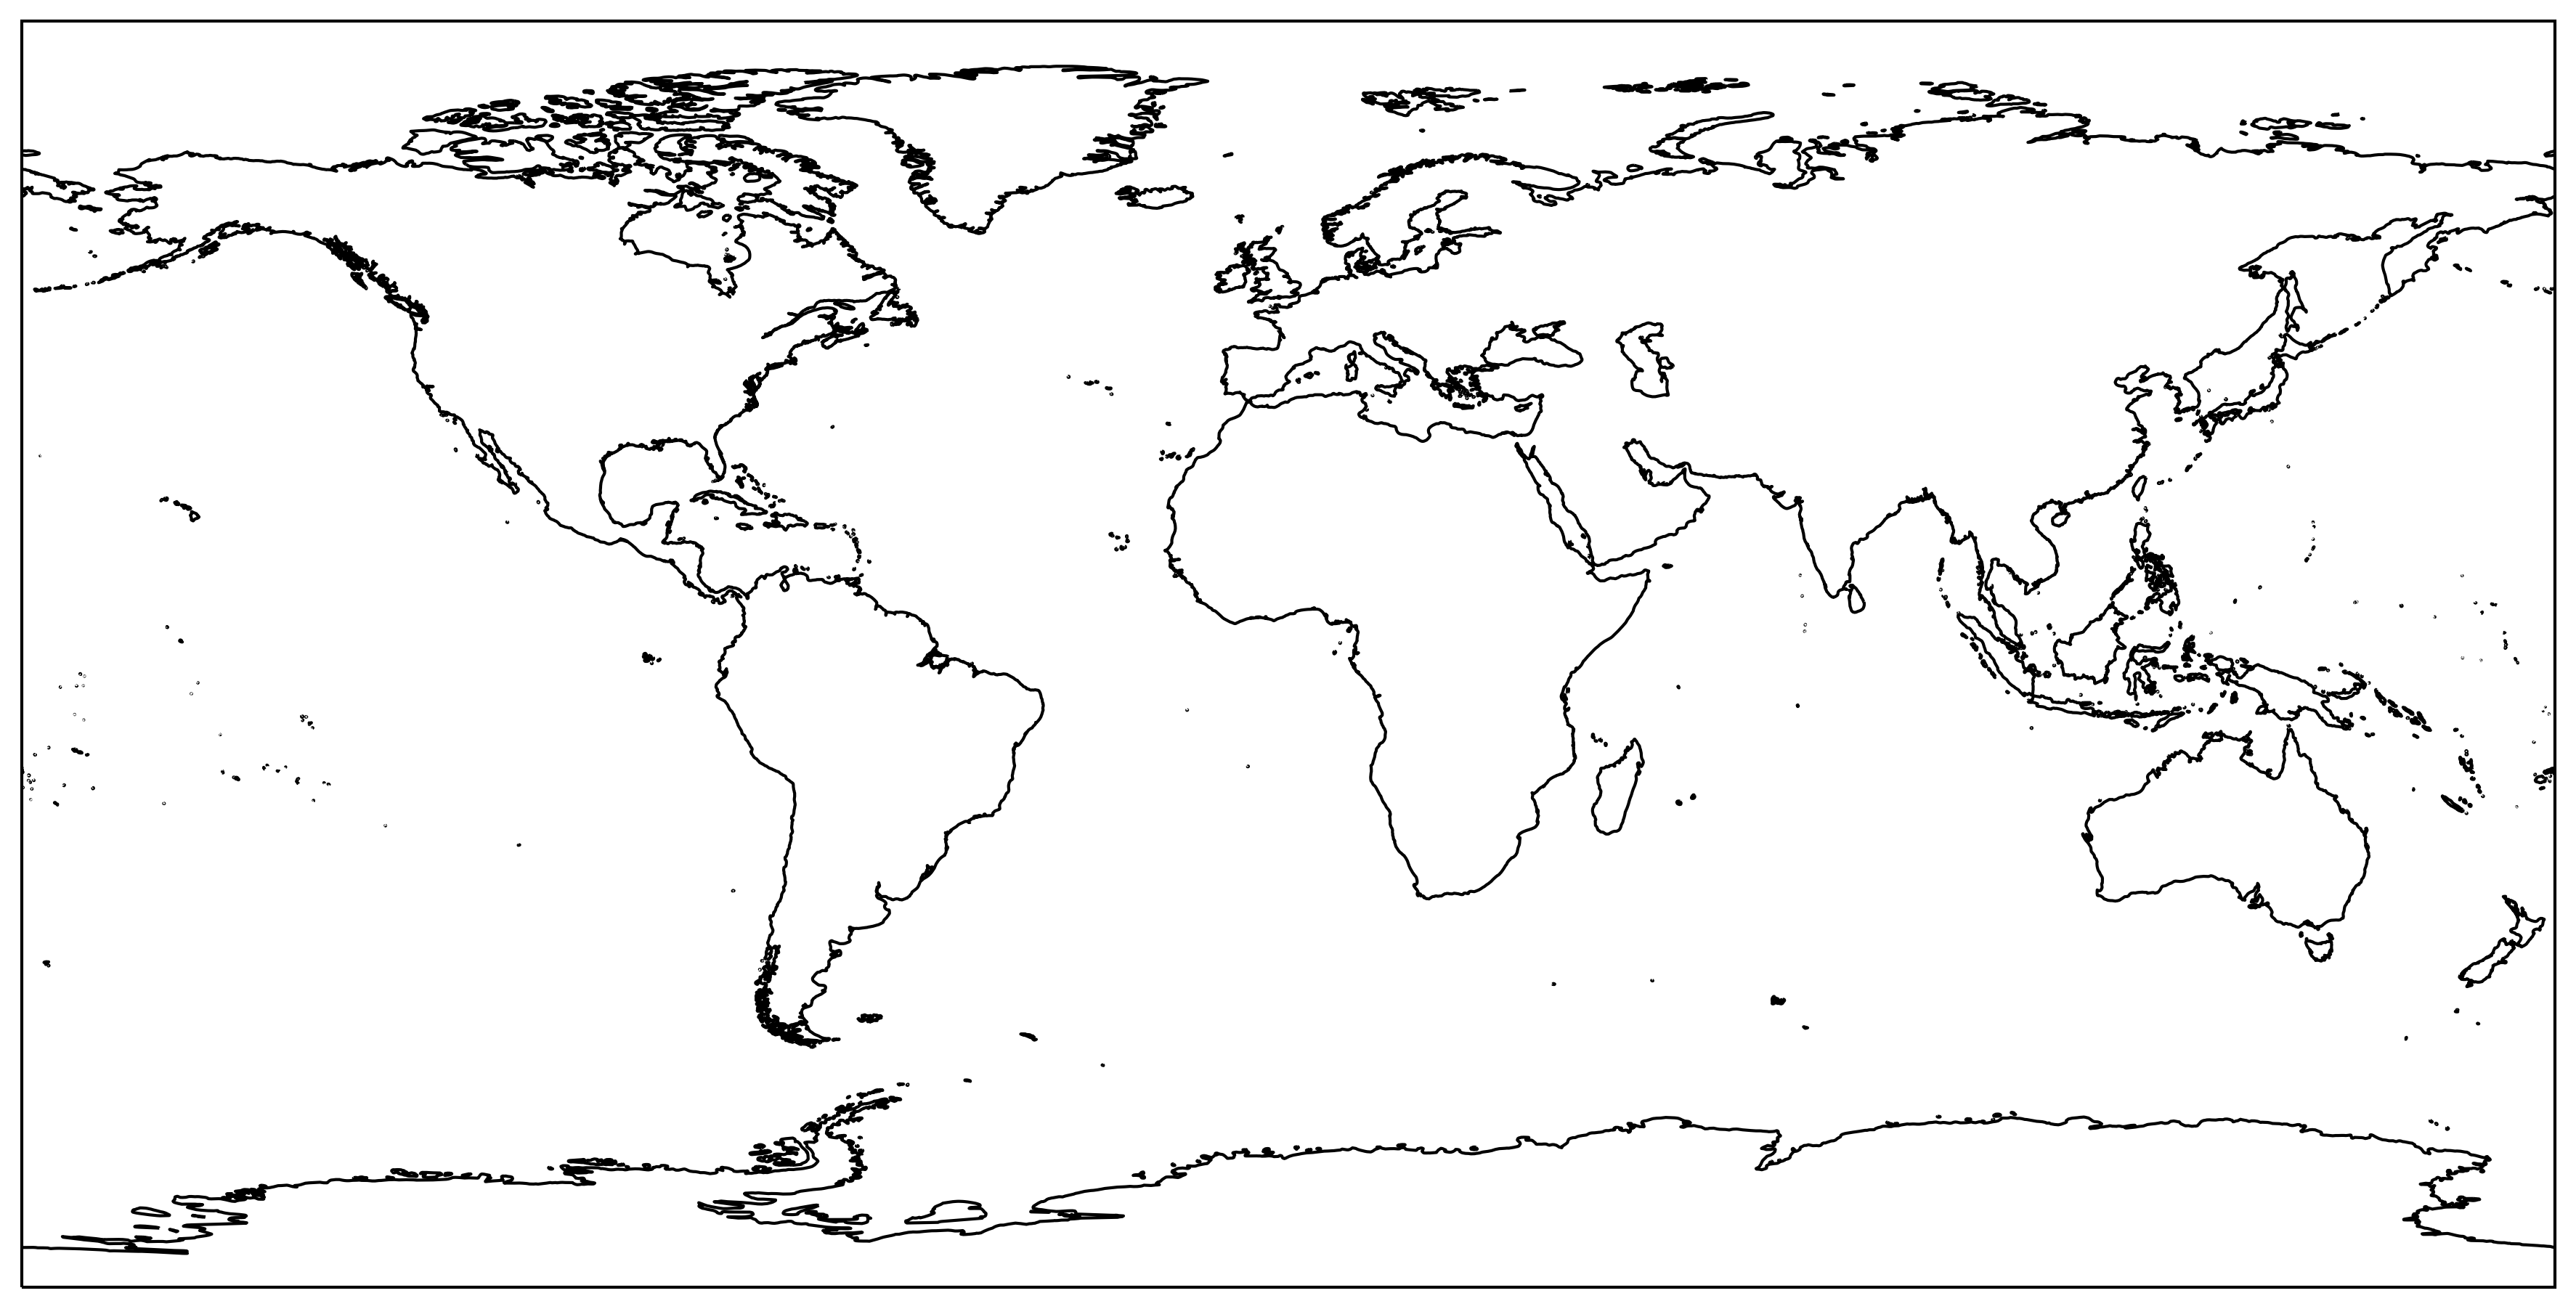

In [39]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import ctables

# Create a new figure
fig = plt.figure(figsize=(15, 12),dpi=300)

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent([-60, -40, -45, -20])

# Retrieve the state boundaries using cFeature and add to plot
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='white')
# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))


# Contour temperature at each lat/long
contours = ax.contourf(lon_2d, lat_2d, temp_2d.to('degC'), 200, transform=ccrs.PlateCarree(),
                       cmap='RdBu_r')
clevel = np.arange(t_min-275,\
                           t_max-275,7)
cs = ax.contour(lon_2d, lat_2d, temp_2d.to('degC'),  clevel, colors='black', transform=ccrs.PlateCarree())


plt.clabel(cs, fmt='%d')


#Plot a colorbar to show temperature and reduce the size of it
fig.colorbar(contours)

# Make a title with the time value
ax.set_title(f'Temperature forecast from GFS 0.25 °C for {str(time_1d[0].values)[:19]}Z', fontsize=20)

# Plot markers for each lat/long to show grid points for 0.25 deg GFS
ax.plot(lon_2d.flatten(), lat_2d.flatten(), linestyle='none', marker='o',
        color='black', markersize=2, alpha=0.3, transform=ccrs.PlateCarree());

In [ ]:
temp_2d.min()
t_min=254.32
temp_2d.max()
t_max=304.32

In [ ]:
t_min